In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import networkx as nx
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MultiLabelBinarizer
from os import listdir
from os.path import isfile, join
from PIL import Image
import pickle

In [3]:
# NUMBER_NODES = 9
NUMBER_NODES = 7
# NUMBER_NODES = 5

def load_data():
    train_ds = tf.keras.utils.image_dataset_from_directory(
        f'./graphs_adj2_{NUMBER_NODES}',
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=(32, 32),
        batch_size=32)
    val_ds = tf.keras.utils.image_dataset_from_directory(
        f'./graphs_adj2_{NUMBER_NODES}',
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=(32, 32),
        batch_size=32)
    return train_ds, val_ds

In [4]:
train_ds, val_ds = load_data()

Found 940 files belonging to 452 classes.
Using 752 files for training.
Found 940 files belonging to 452 classes.
Using 188 files for validation.


In [5]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(NUMBER_NODES, NUMBER_NODES, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

class_names = train_ds.class_names
num_classes = len(class_names)

# Save test_Data to use it in compareResults (output_band, optimal_band, reverse-cuthill-mckee_band)
with open(os.path.join(os.path.abspath(''), 'class_names.pickle'), 'wb') as f:
    pickle.dump(class_names, f, pickle.HIGHEST_PROTOCOL)

In [6]:
model = models.Sequential()
# model.add(data_augmentation)
model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(NUMBER_NODES, NUMBER_NODES, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=128,
)

Epoch 1/128
24/24 [==============================] - 2s 60ms/step - loss: 6.0010 - accuracy: 0.0811 - val_loss: 5.9252 - val_accuracy: 0.1011
Epoch 2/128
24/24 [==============================] - 1s 50ms/step - loss: 5.7288 - accuracy: 0.0918 - val_loss: 6.0320 - val_accuracy: 0.1011
Epoch 3/128
24/24 [==============================] - 1s 48ms/step - loss: 5.5068 - accuracy: 0.0957 - val_loss: 6.1706 - val_accuracy: 0.1170
Epoch 4/128
24/24 [==============================] - 1s 48ms/step - loss: 5.3204 - accuracy: 0.0997 - val_loss: 6.2360 - val_accuracy: 0.1223
Epoch 5/128
24/24 [==============================] - 1s 48ms/step - loss: 5.0502 - accuracy: 0.1130 - val_loss: 6.4590 - val_accuracy: 0.1277
Epoch 6/128
24/24 [==============================] - 1s 48ms/step - loss: 4.7132 - accuracy: 0.1223 - val_loss: 6.6969 - val_accuracy: 0.1383
Epoch 7/128
24/24 [==============================] - 1s 48ms/step - loss: 4.3150 - accuracy: 0.1543 - val_loss: 7.2289 - val_accuracy: 0.1543
Epoch 

In [7]:
model.save('CNN_dir_adj2_model')

INFO:tensorflow:Assets written to: CNN_dir_adj2_model\assets


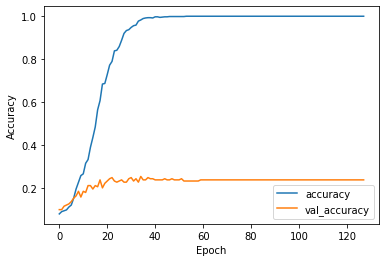

In [8]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

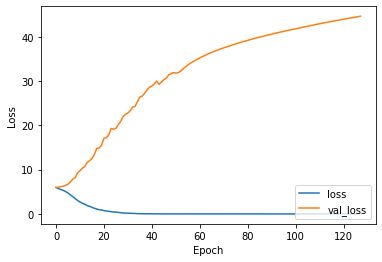

In [9]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [10]:
def get_bandwidth(Graph, nodelist):
    Graph = nx.Graph(Graph)
    if not Graph.edges:
        return 0
    L = nx.laplacian_matrix(Graph, nodelist=nodelist)
    x, y = np.nonzero(L)
    return (x-y).max()

def processDataToAdjImage(graphInput):
    adj = getGraph(graphInput)
    w, h = NUMBER_NODES, NUMBER_NODES
    data = np.zeros((h, w, 3), dtype=np.uint8)
    for i in range(len(adj)):
        for j in range(len(adj)):
            if adj[i, j] == 1:
                data[i, j] = np.array([255.0, 255.0, 255.0])
    # data /= 255.0
    img = Image.fromarray(data, 'RGB')
    resized = img.resize((32, 32), Image.NEAREST)
    image_input_np = np.array(resized)
    return image_input_np

def getGraph(upperTriangleAdjMatrix):
    dense_adj = np.zeros((NUMBER_NODES, NUMBER_NODES))
    dense_adj = np.zeros((NUMBER_NODES, NUMBER_NODES))
    k = 0
    for i in range(NUMBER_NODES):
        for j in range(NUMBER_NODES):
            if i == j:
                continue
            elif i < j:
                dense_adj[i][j] = upperTriangleAdjMatrix[k]
                k += 1
            else:
                dense_adj[i][j] = dense_adj[j][i]
    return dense_adj

def getArray(strArray):
    arr = strArray.split('.')
    first = strArray[1]
    arr = [first, *arr[1 : -1]] # skip '[' and ']'
    arr = list(map(lambda x: int(x.strip()), arr))
    return arr

In [11]:
def load_test_data():
    NUMBER_NODES=7
    df = pd.read_csv(f'./test_adj2_graphs_{NUMBER_NODES}/teste_data2_{NUMBER_NODES}.csv')
    print(df.shape)

    featuresNumber = ((NUMBER_NODES * NUMBER_NODES - NUMBER_NODES) // 2 )
    features = df.iloc[ : , : featuresNumber ].values
    labels = df.iloc[ : , featuresNumber + 1 : ].values # skip bandwidth value
    return features, labels

In [12]:
test_features, test_labels = load_test_data()
print(test_features.shape)
print(test_labels.shape)

(104, 29)
(104, 21)
(104, 7)


In [13]:
sumTest_pred = 0
sumTest_true = 0

for x, true in zip(test_features, test_labels):
    get_graph_adj_image_arr = processDataToAdjImage(x)
    pred = model.predict(np.array([get_graph_adj_image_arr]))
    print("===")
    try:
        print(np.argmax(pred))
        print(class_names.index(str(true)))
    except ValueError:
        print(f"{str(true)} not in class_names")
    
    print("as node list:")
    str_pred_nodelist = class_names[np.argmax(pred)]
    true_nodelist = list(map(int, true))
    print(str_pred_nodelist)
    print(true_nodelist)
    print("Bandwidth")
    arr_pred_nodelist = getArray(str_pred_nodelist)
    arr_true_nodelist = true_nodelist
    graph = getGraph(x)
    
    pred_band = get_bandwidth(graph, arr_pred_nodelist)
    sumTest_pred += pred_band
    true_band = get_bandwidth(graph, arr_true_nodelist)
    sumTest_true += true_band
    print(pred_band)
    print(true_band)

===
149
[1. 6. 2. 5. 0. 3. 4.] not in class_names
as node list:
[1. 6. 2. 0. 5. 3. 4.]
[1, 6, 2, 5, 0, 3, 4]
Bandwidth
1
1
===
137
216
as node list:
[1. 5. 6. 0. 2. 4. 3.]
[2, 4, 6, 0, 5, 1, 3]
Bandwidth
2
2
===
263
[0. 1. 6. 5. 4. 3. 2.] not in class_names
as node list:
[3. 0. 6. 4. 5. 1. 2.]
[0, 1, 6, 5, 4, 3, 2]
Bandwidth
3
3
===
351
[4. 3. 2. 6. 0. 5. 1.] not in class_names
as node list:
[4. 1. 0. 6. 5. 3. 2.]
[4, 3, 2, 6, 0, 5, 1]
Bandwidth
3
3
===
126
132
as node list:
[1. 5. 0. 6. 4. 2. 3.]
[1, 5, 4, 0, 6, 2, 3]
Bandwidth
2
1
===
126
[1. 5. 3. 4. 0. 6. 2.] not in class_names
as node list:
[1. 5. 0. 6. 4. 2. 3.]
[1, 5, 3, 4, 0, 6, 2]
Bandwidth
2
1
===
123
[1. 5. 0. 4. 2. 6. 3.] not in class_names
as node list:
[1. 5. 0. 3. 6. 2. 4.]
[1, 5, 0, 4, 2, 6, 3]
Bandwidth
4
1
===
329
262
as node list:
[3. 6. 4. 0. 2. 5. 1.]
[3, 0, 6, 4, 2, 5, 1]
Bandwidth
3
2
===
137
137
as node list:
[1. 5. 6. 0. 2. 4. 3.]
[1, 5, 6, 0, 2, 4, 3]
Bandwidth
2
2
===
139
139
as node list:
[1. 5. 6. 0. 4. 3. 

In [14]:
print("Pred bandwidth mean")
print(sumTest_pred / test_features.shape[0])
print("True bandwidth mean")
print(sumTest_true / test_features.shape[0])

Pred bandwidth mean
3.4615384615384617
True bandwidth mean
3.0865384615384617
